In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


In [4]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_config
from src.vit_cluster_train import ViTDeepClusterTrainer
from src.vit_data_clustering import ViTDataDeepClustering
from src.vit_data import load_cell_cycle_data
import importlib

config_name = 'deep_clustering_test'
config = importlib.import_module(f"config.{config_name}")

vit = load_model_config(config)
vit_data = load_cell_cycle_data(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM, 
                                init_class=ViTDataDeepClustering, debug_n=None)

In [5]:
times = np.array(sorted(list(set(vit_data.times))))
times

array([  0.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 120.,
       130., 140.])

In [11]:
cc_prom_tf = pd.read_csv('data/yulong_cell_cycle_paper_Table_S2_promoter_TF.csv').set_index('Gene_ID')
cc_prom_tf = cc_prom_tf.loc[list(set(vit_data.orfs)\
    .intersection(set(cc_prom_tf.index)))].sort_values('Fourier_score', ascending=False)
cc_prom_tf.head(2)

,Gene_name,Fourier_score,P_value,FDR
Gene_ID,,,,
YPR119W,CLB2,9.134776,0.00005,0.050818
YNL058C,YNL058C,8.975835,0.00012,0.055900


In [13]:
orf_names = vit_data.read_log_tpm_data().index.values
len(orf_names)

4427

In [14]:
cc_dat = pd.DataFrame(index=orf_names).join(cc_set, how='left')
cc_dat['idx'] = np.arange(len(cc_dat))
cc_dat.head(2)

,Gene_name,Fourier_score,P_value,FDR,Cell_cycle_phase,idx
YAL063C,FLO9,4.263286,0.28523,0.438953,NaN,0
YAL062W,GDH3,2.074419,0.77236,0.830606,NaN,1


In [15]:
cell_cycle_genes_rna = cc_dat[cc_dat.FDR < fdr_cutoff]
len(cell_cycle_genes_rna)

881

In [16]:
cc_idx = cell_cycle_genes_rna.idx.values

In [17]:
imgs = vit_data.all_imgs

In [18]:
from src.attention_analysis import pivot_images

pivoted_images = pivot_images(imgs, times)

In [19]:
import cv2
from src.timer import Timer

timer = Timer()

att_size = (3, 16)
imgs_resized = np.zeros((len(vit_data), 2, att_size[0], att_size[1]))

for i in range(len(vit_data.all_imgs)):
    cur_img = vit_data.all_imgs[i]
    for channel in range(cur_img.shape[0]):
        img_resize = cv2.resize(cur_img[channel], (att_size[1], att_size[0]))
        imgs_resized[i, channel] = img_resize
    timer.print_progress(i, len(vit_data.all_imgs), every=20000)


0/57551 - 00:00:00.01
20000/57551 - 00:00:00.23
40000/57551 - 00:00:00.46


In [20]:
from src.utils import write_pickle

#write_pickle(imgs_resized, 'data/vit/cell_cycle_24x128_p1/resized_imgs_all.pkl')


In [21]:
resize_pivoted = pivot_images(imgs_resized, times)
resize_pivoted.shape

(4427, 2, 13, 3, 16)

In [22]:
# Store the score itself and the period (in minutes) as the second dimension
fourier_scores = np.zeros((resize_pivoted.shape[0], 2, resize_pivoted.shape[1],
                           resize_pivoted.shape[3], resize_pivoted.shape[4]))


In [23]:
fourier_scores.shape

(4427, 2, 2, 3, 16)

In [361]:
times

array([  0.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 120.,
       130., 140.])

In [370]:
from src.timer import Timer
from src.attention_analysis import fourier_score

timer = Timer()

for idx in range(resize_pivoted.shape[0]):
    for channel in range(resize_pivoted.shape[1]):
        for i in range(resize_pivoted.shape[3]):
            for j in range(resize_pivoted.shape[4]):
                vals = resize_pivoted[idx, channel, :, i, j]
                new_vals = vals
                score, offset = fourier_score(new_vals[1:], times[1:], period=63, highest_offset=140)
                fourier_scores[idx, :, channel, i, j] = np.array([score, offset])
    timer.print_progress(idx, resize_pivoted.shape[0], every=1000)

0/4427 - 00:00:00.28
1000/4427 - 00:04:35.34
2000/4427 - 00:09:07.79
3000/4427 - 00:13:45.19
4000/4427 - 00:18:17.71


In [547]:
import numpy as np
import matplotlib.pyplot as plt

def _plot_annotations(ax, ylim):

    ax.set_xticks([])
    ax.set_xlim(0, -2*math.pi)

    cmap = plt.get_cmap('tab10')
    phases = \
        [
            ('G1', (0, 20), cmap(3)),
            ('S', (20, 45), cmap(2)),
            ('G2', (45, 55), cmap(0)),
            ('M', (55, 63), cmap(4)),
        ]

    period = 63
    xticks = []
    xticklabels = []
    for phase in phases:
        phase_time_min = phase[1][0], phase[1][1]
        color = phase[2]
        phase_time_rads = -2*math.pi * phase_time_min[0]/period, -2*math.pi * phase_time_min[1]/period
        ax.fill_between([phase_time_rads[0], phase_time_rads[1]], [0, 0], [100, 100],
                        color=color, alpha=0.1, zorder=0)
        ax.text(s=phase[0], x=(phase_time_rads[0]+phase_time_rads[1])/2, y=ylim*0.75, 
                color=color, fontsize=18, zorder=0)
        xticks.append(phase_time_rads[0])

        xticklabels.append(f"{phase_time_min[0]}'")
    ax.set_xticks(xticks, xticklabels, fontsize=12)
    ax.set_yticks(np.arange(0, 10, 2), ['' for _ in np.arange(0, 10, 2)])
    ax.set_ylim(0, ylim)
    
def plot_polar(p1_offsets, p1_scores, ylim=6, selected=None, ax=None):
    def to_rads(deg):
        return deg / 180. * math.pi

    if ax is None:
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(4, 4))
    
    x, y = -p1_offsets/63 * 2*math.pi, p1_scores

    ax.scatter(x, y, s=4, c='gray')
    
    if selected is not None:
        ax.scatter(x[selected], y[selected], s=4, c='red')

    _plot_annotations(ax, ylim)

In [376]:
small_prom_fourier = fourier_scores[:, :, :, 0, 6].max(axis=2)
small_score = small_prom_fourier[:, 0]
small_offsets = small_prom_fourier[:, 1]


In [379]:
cc_phases = tpm_data.join(rna_cc)

In [380]:
cc_phases.Cell_cycle_phase.value_counts()

G1      369
S       214
G2/M     44
S/G2     36
M/G1     19
Name: Cell_cycle_phase, dtype: int64

In [382]:
rna_cc_genes_idx = np.arange(len(cc_phases))[~cc_phases.Cell_cycle_phase.isna()]
G1_cc_genes_idx = np.arange(len(cc_phases))[cc_phases.Cell_cycle_phase == 'G1']
S_cc_genes_idx = np.arange(len(cc_phases))[cc_phases.Cell_cycle_phase == 'S']
G2M_cc_genes_idx = np.arange(len(cc_phases))[cc_phases.Cell_cycle_phase == 'G2/M']
SG2_cc_genes_idx = np.arange(len(cc_phases))[cc_phases.Cell_cycle_phase == 'S/G2']
MG1_cc_genes_idx = np.arange(len(cc_phases))[cc_phases.Cell_cycle_phase == 'M/G1']


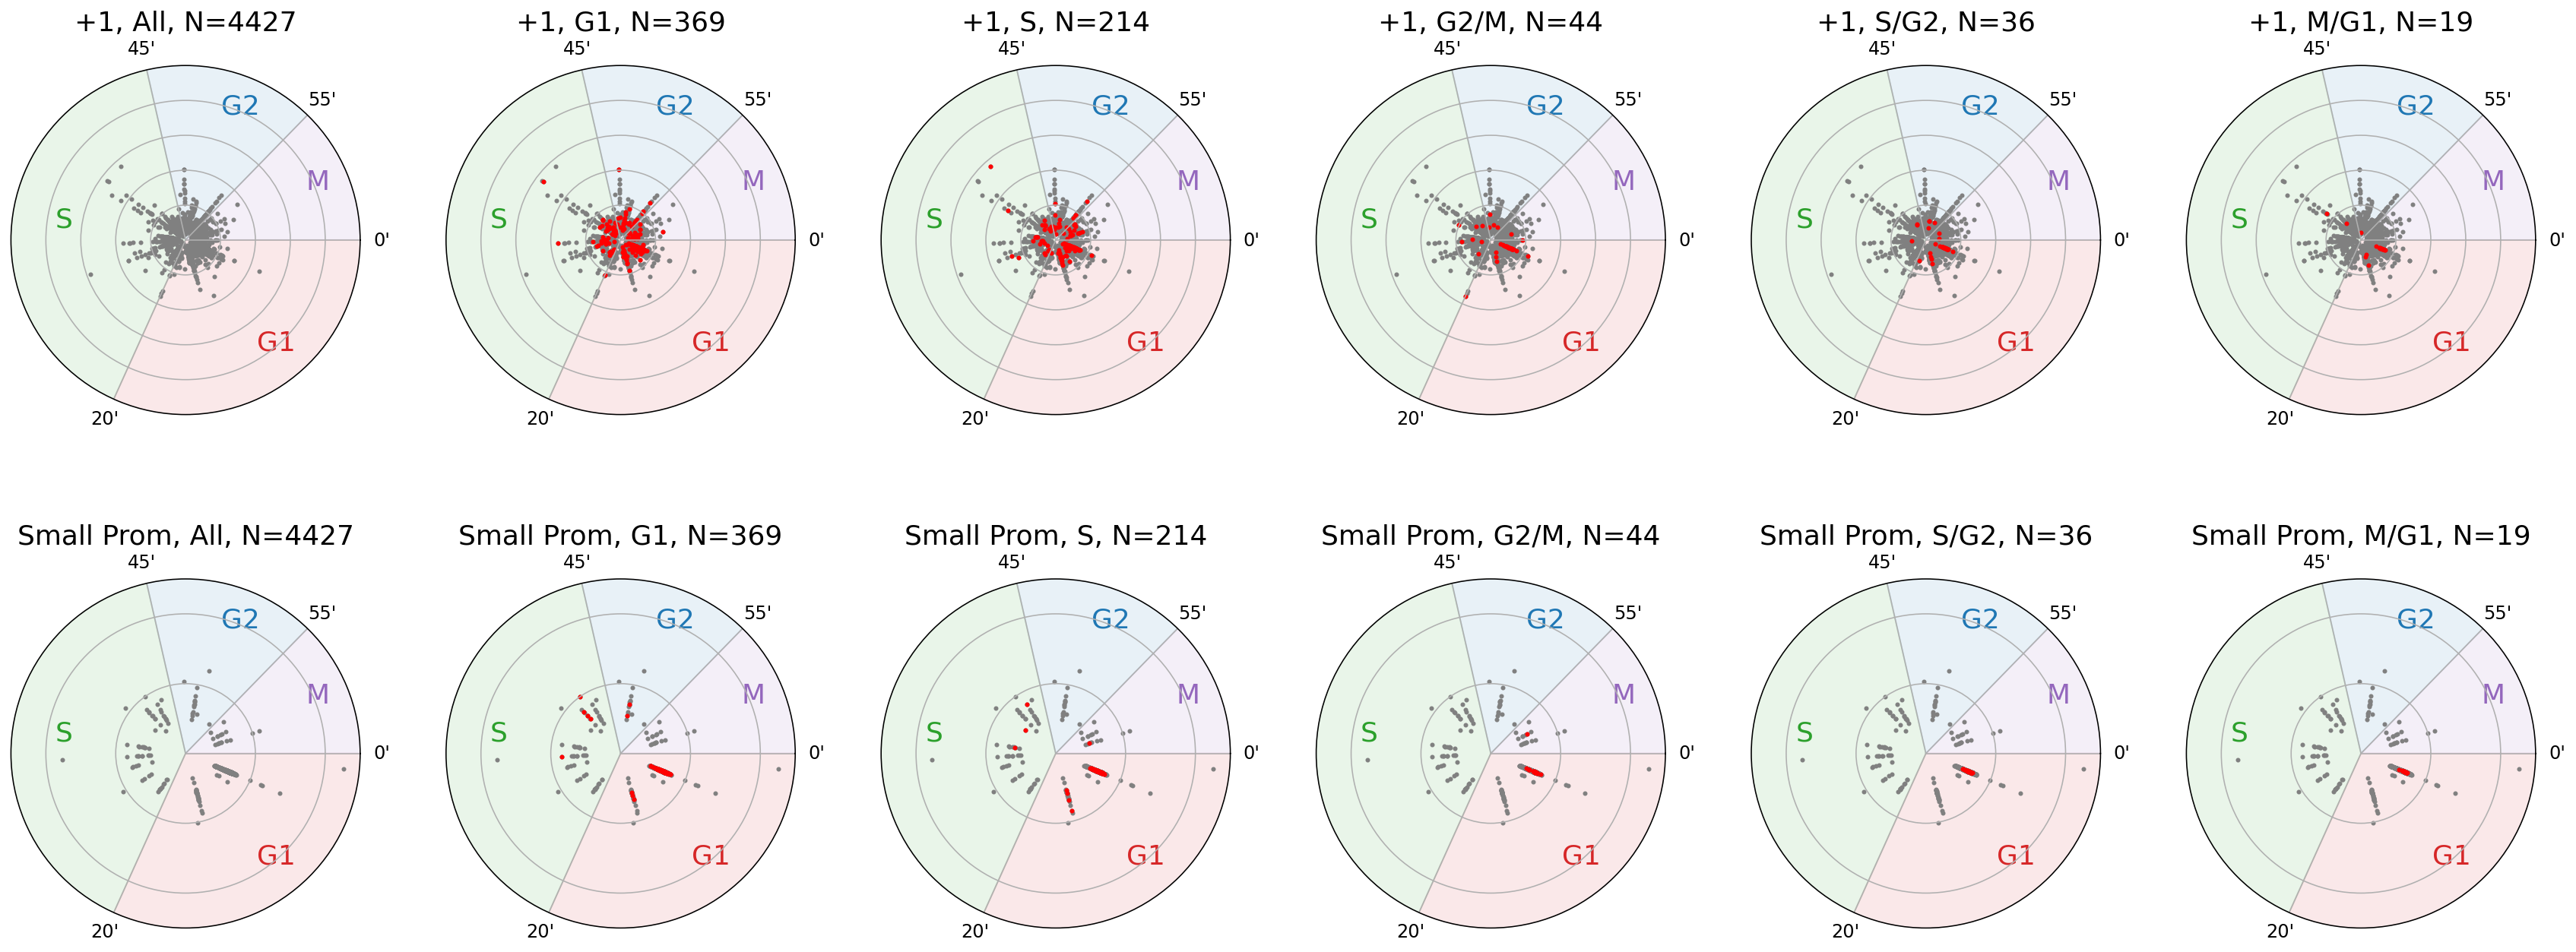

In [548]:
fig, axes = plt.subplots(2, 6, subplot_kw={'projection': 'polar'}, figsize=(24, 9))
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)
    
axes = np.array(axes).flatten()

selections = [[False]*len(small_offsets), G1_cc_genes_idx, S_cc_genes_idx, G2M_cc_genes_idx, 
              SG2_cc_genes_idx, MG1_cc_genes_idx]
titles = ['All', 'G1', 'S', 'G2/M', 'S/G2', 'M/G1']

for i in range(len(selections)):
    ax = axes[i]
    plot_polar(p1_offsets, p1_scores, selected=selections[i], ylim=10, ax=ax)
    ax.set_title(f"+1, {titles[i]}, N={len(selections[i])}", fontsize=18)

for i in range(len(selections)):
    ax = axes[i+len(selections)]
    plot_polar(small_offsets, small_score, selected=selections[i], ylim=5, ax=ax)
    ax.set_title(f"Small Prom, {titles[i]}, N={len(selections[i])}", fontsize=18)

In [489]:
p1_occ_idx_max = (resize_pivoted[:, :, 1:, 2, 8].argmax(axis=2)+1)*10
p1_occ_max = resize_pivoted[:, :, 1:, 2, 8].max(axis=2)

sm_occ_idx_max = (resize_pivoted[:, 1:, :, 0, 6].argmax(axis=2)+1)*10
sm_occ_max = resize_pivoted[:, :, 1:, 0, 6].max(axis=2)


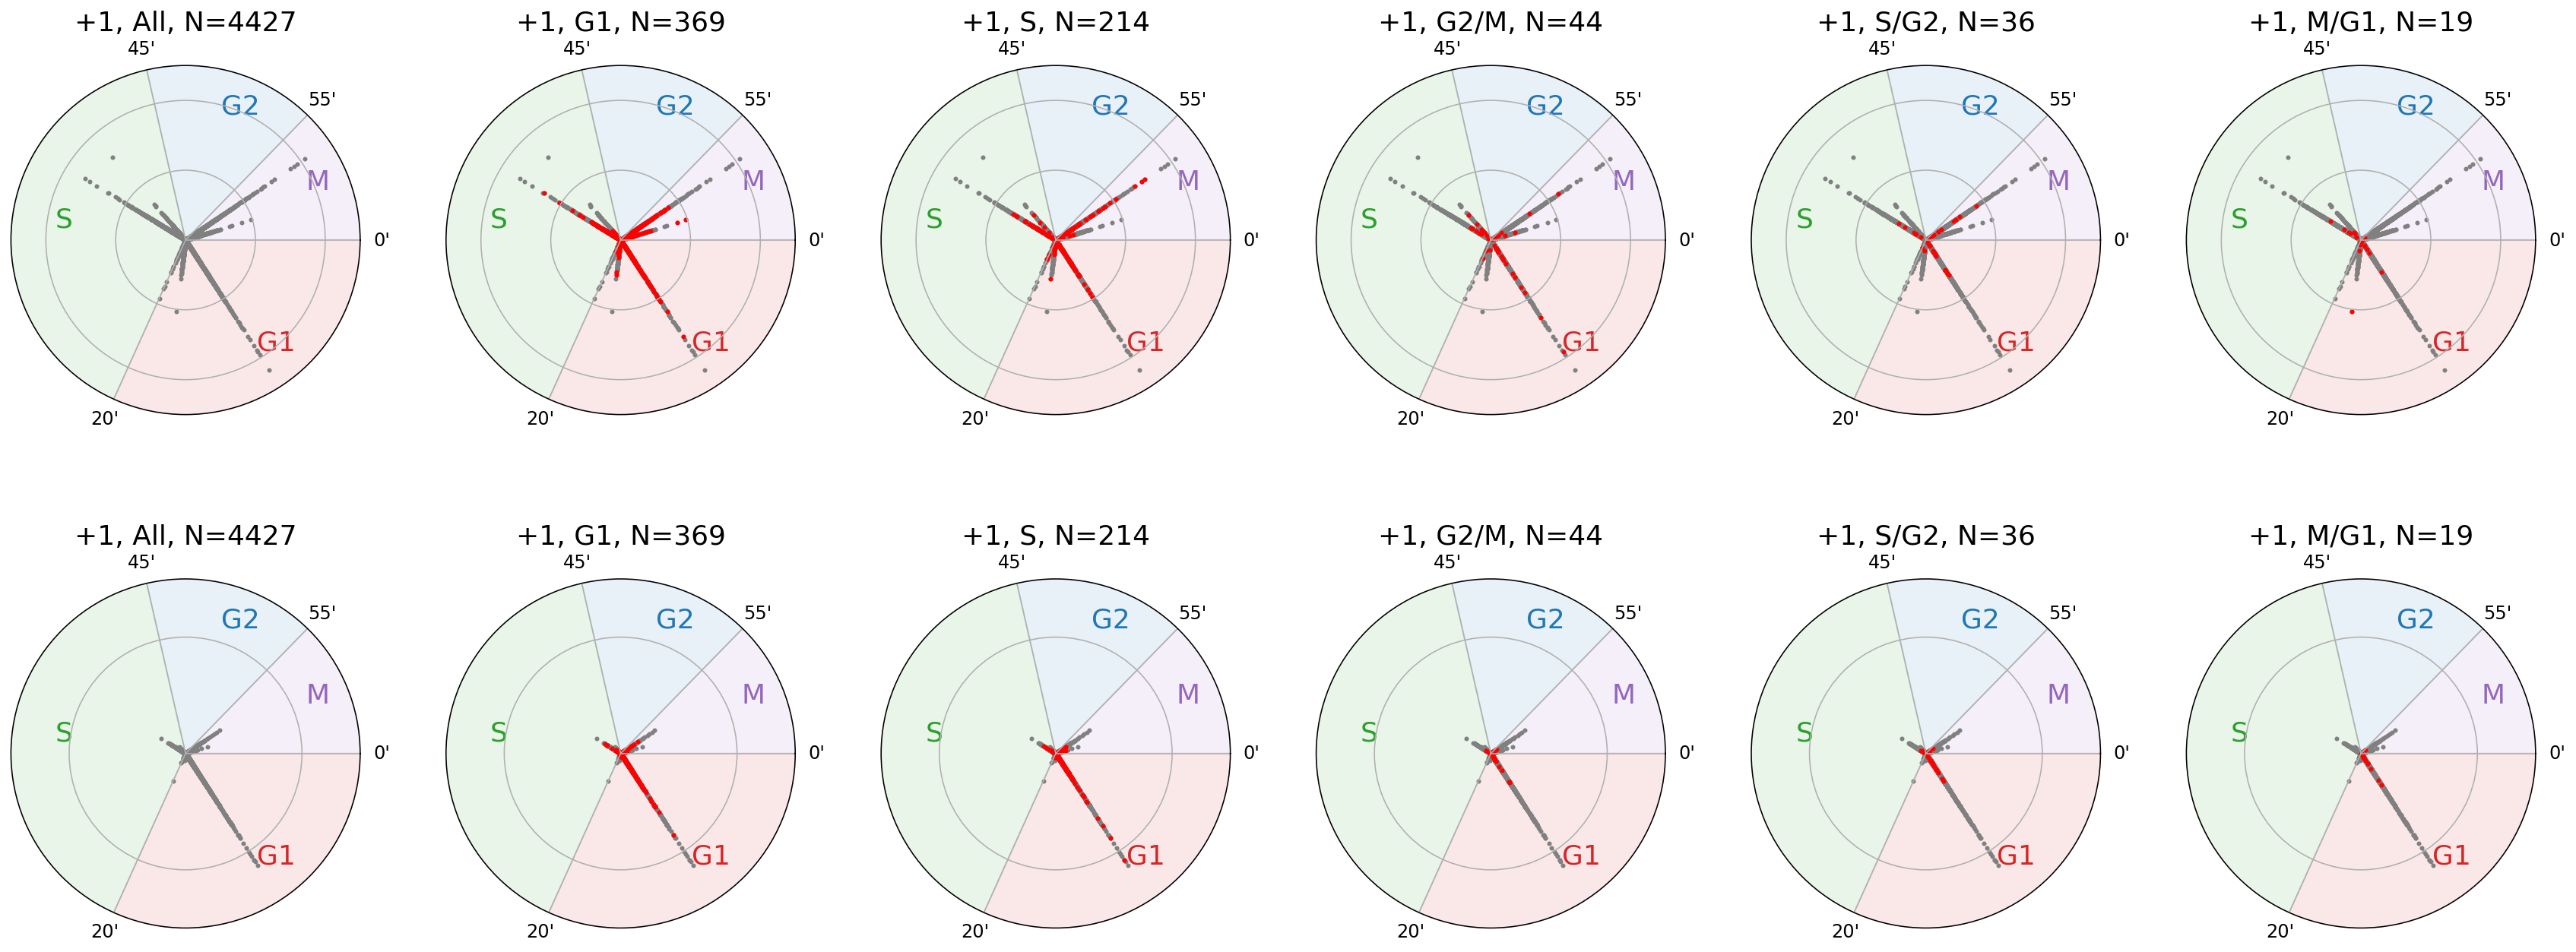

In [499]:
fig, axes = plt.subplots(2, 6, subplot_kw={'projection': 'polar'}, figsize=(24, 9))
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)
    
axes = np.array(axes).flatten()

for i in range(len(selections)):
    ax = axes[i]
    plot_polar(p1_occ_idx_max[:, 0], p1_occ_max[:, 0]+1, selected=selections[i], ylim=5, ax=ax)
    ax.set_title(f"+1, {titles[i]}, N={len(selections[i])}", fontsize=18)

for i in range(len(selections)):
    ax = axes[i+len(selections)]
    plot_polar(sm_occ_idx_max[:, 0], sm_occ_max[:, 0]+1, selected=selections[i], ylim=3, ax=ax)
    ax.set_title(f"+1, {titles[i]}, N={len(selections[i])}", fontsize=18)


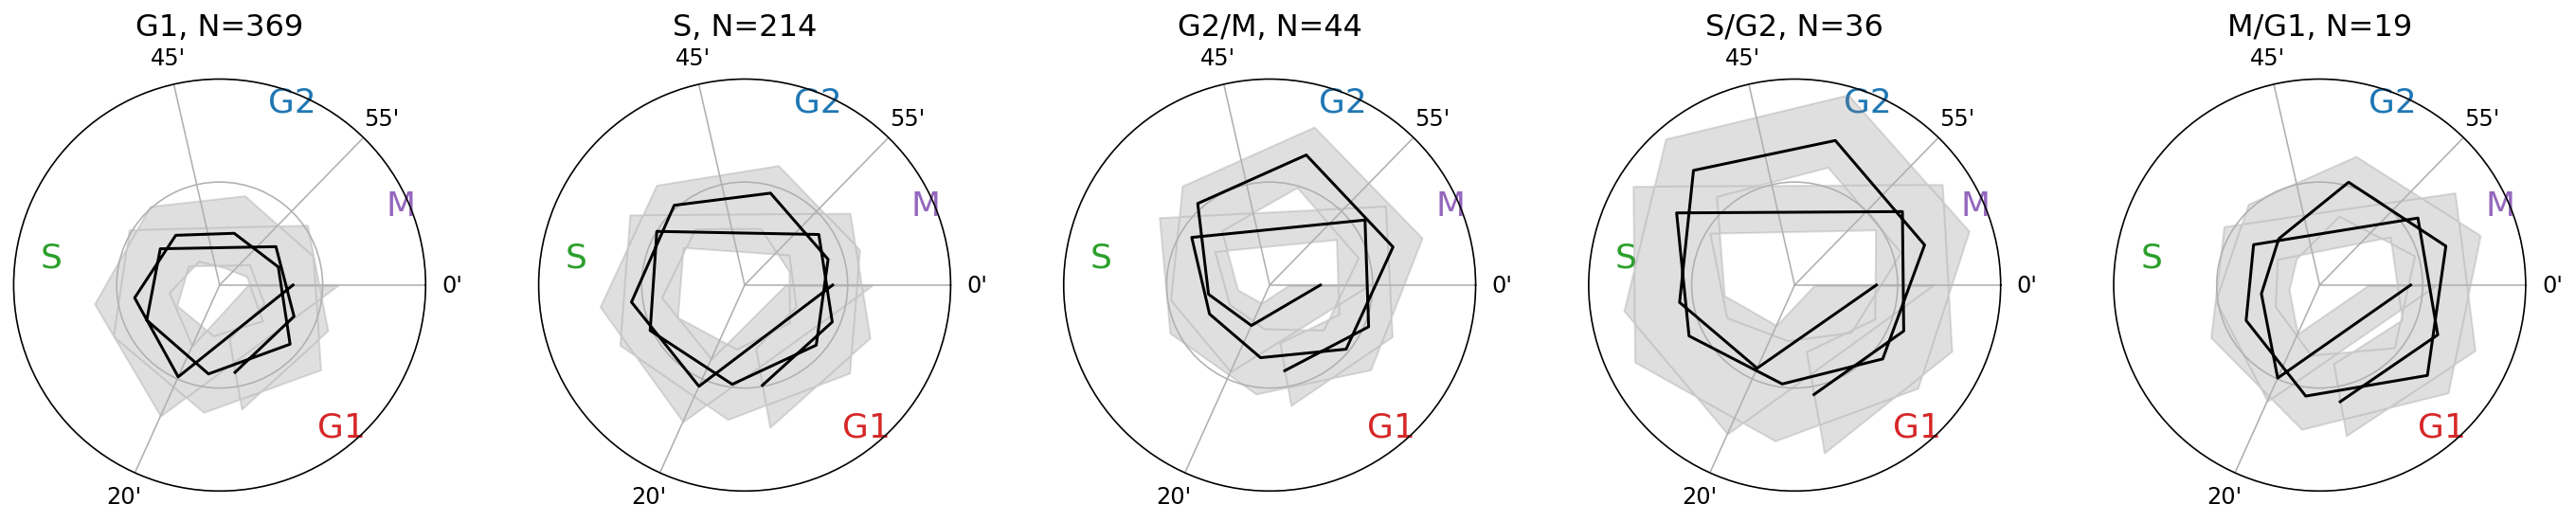

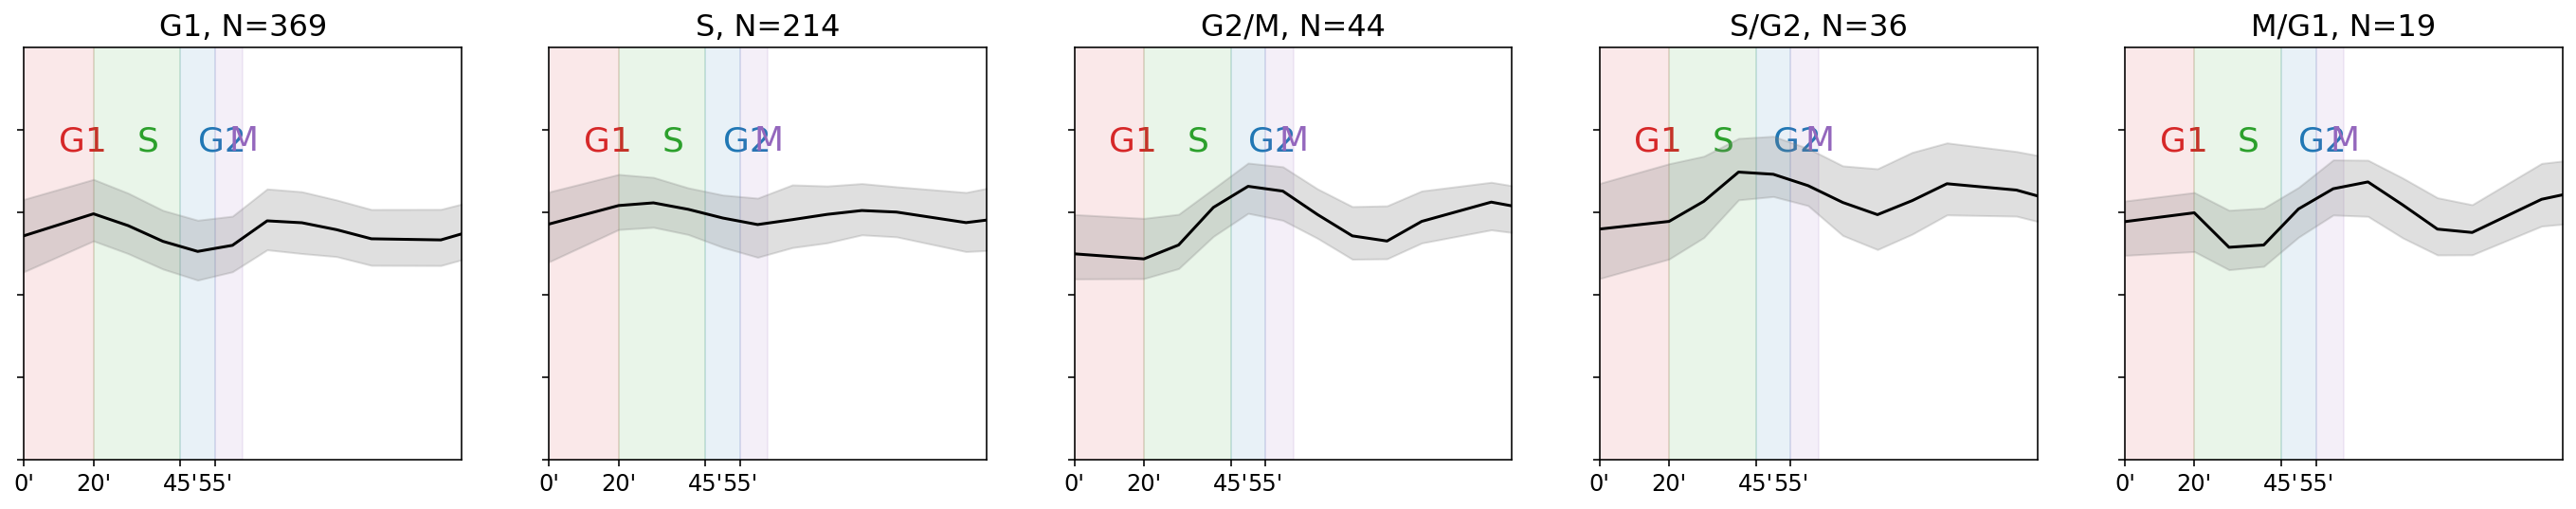

In [584]:
fig, axs = plt.subplots(1, 5, subplot_kw={'projection': 'polar'}, figsize=(24, 4))

phases = cc_phases.Cell_cycle_phase.unique()[1:]
times_radians = times / 63 * 2*math.pi

for i in range(len(phases)):
    phase = phases[i]
    ax = axs[i]
    g1_set = cc_phases[cc_phases.Cell_cycle_phase == phase]

    ax.plot(-times_radians, g1_set[times].median(), color='black')
    ax.fill_between(-times_radians, g1_set[times].quantile(0.75), g1_set[times].quantile(0.25),
                    color='gray', alpha=0.25)
    _plot_annotations(ax, 10)
    ax.set_title(f"{phase}, N={len(g1_set)}", fontsize=16)
    ax.set_ylim(4, 8)

fig, axs = plt.subplots(1, 5, figsize=(24, 4))
for i in range(len(phases)):
    phase = phases[i]
    ax = axs[i]
    g1_set = cc_phases[cc_phases.Cell_cycle_phase == phase]

    ax.plot(-times_radians, g1_set[times].median(), color='black')
    ax.fill_between(-times_radians, g1_set[times].quantile(0.75), g1_set[times].quantile(0.25),
                    color='gray', alpha=0.25)
    _plot_annotations(ax, 10)
    ax.set_title(f"{phase}, N={len(g1_set)}", fontsize=16)
    ax.set_xlim(0, -2*math.pi*2)
